<a href="https://colab.research.google.com/github/joaochenriques/MCTE_2022/blob/main/ChannelFlows/CpMaxCurves/CpMaxCurves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sympy as sp
import numpy as np
from scipy.optimize import fsolve, fmin, minimize_scalar, curve_fit
import matplotlib.pyplot as mpl
%config InlineBackend.figure_formats = ['svg']
mpl.rcParams["figure.figsize"] = (7, 3.5)

# **Warning**

Before running this notebook locus of optimal values of $C_P$ as function of $C_T$ and $\mathrm{Fr}_1$ in the notebook: 

https://github.com/joaochenriques/MCTE_2020_2021/blob/main/DiskActuator/Sensitivity_Analysis.ipynb

In [ ]:
def compute_C_T_and_C_P( Fr4b, Fr1, B ): 

    # These Eqs. are described in
    # https://github.com/joaochenriques/MCTE_2020_2021/blob/main/DiskActuator/DiskActuator.ipynb

    ζ4 = (1/2.)*Fr1**2 - 1/2.*Fr4b**2 + 1.0
    
    Fr4t = (Fr1 - Fr4b*ζ4 + np.sqrt(B**2*Fr4b**2 - 2*B*Fr1**2 + 2*B*Fr1*Fr4b \
            + B*ζ4**2 - B + Fr1**2 - 2*Fr1*Fr4b*ζ4 + Fr4b**2*ζ4**2))/B

    ζ4b =  (Fr1 - Fr4t*ζ4)/(Fr4b - Fr4t)
    ζ4t = -(Fr1 - Fr4b*ζ4)/(Fr4b - Fr4t)
    
    Fr2t = Fr4t*ζ4t/B

    C_T = (Fr4b**2 - Fr4t**2)/Fr1**2
    C_P = C_T*Fr2t/Fr1

    return C_T, C_P

def find_minus_C_P( Fr4b, Fr1, B ): 
    # function created to discard the C_T when calling "compute_C_T_and_C_P"
    C_T, C_P = compute_C_T_and_C_P( Fr4b, Fr1, B ) 
    return -C_P # Minus C_P to allow minimization

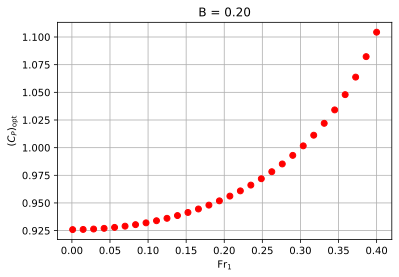

In [ ]:
# Blockage factor 
B = 0.2

# define Fr1 interval and number of points
Fr1_min = 1E-3
Fr1_max = 0.4
Fr1_num = 30

Fr1_opt_vec = np.linspace( Fr1_min, Fr1_max, Fr1_num )

C_P_opt_vec = np.zeros( Fr1_num )
C_T_opt_vec = np.zeros( Fr1_num )

for i, Fr1 in enumerate( Fr1_opt_vec ):

  res = minimize_scalar( find_minus_C_P, args=(Fr1, B), bounds=[0,1], method='bounded', 
                         options={ 'xatol': 1e-08, 'maxiter': 500, 'disp': 1 } )
  Fr4b = res.x # optimal value

  C_T, C_P = compute_C_T_and_C_P( Fr4b, Fr1, B )

  C_T_opt_vec[i] = C_T
  C_P_opt_vec[i] = C_P
  
mpl.plot( Fr1_opt_vec, C_P_opt_vec, 'ro' )
mpl.title( "B = %.2f" % B )
mpl.xlabel("$\mathrm{Fr}_1$")
mpl.ylabel("$(C_P)_\mathrm{opt}$")
mpl.grid()

## **Polynomial fitting**

Fit a polynomial of the type 

$$ a x^6 + b x^4 + c x^2 + d$$

to the optimal $C_T$ and $C_P$. This polynomial has only even monomial to avoid double curvature.


In [ ]:
def fitting_func( x, a, b, c, d ):
    x2 = x*x
    return ( ( ( a * x2 + b ) * x2 + c ) * x2 ) + d

C_P_popt, C_P_pcov = curve_fit( fitting_func, Fr1_opt_vec, C_P_opt_vec )
C_T_popt, C_P_pcov = curve_fit( fitting_func, Fr1_opt_vec, C_T_opt_vec )

## **Optimal $C_T$ and $C_P$**

In [ ]:
sFr_1, sC_P, sC_T = sp.symbols( "\mathrm{Fr}_1, C_\mathrm{P}, C_\mathrm{T}" )
eqCP = sp.Eq( sC_P, fitting_func( sFr_1, *C_P_popt ) )
sp.expand( eqCP )

Eq(C_\mathrm{P}, 18.3172304543468*\mathrm{Fr}_1**6 - 0.331360143237479*\mathrm{Fr}_1**4 + 0.694619408775863*\mathrm{Fr}_1**2 + 0.925613506857598)

In [ ]:
eqCT = sp.Eq( sC_T, fitting_func( sFr_1, *C_T_popt ) )
sp.expand( eqCT )

Eq(C_\mathrm{T}, 111.203860022841*\mathrm{Fr}_1**6 - 7.9213645091785*\mathrm{Fr}_1**4 + 2.19785364213201*\mathrm{Fr}_1**2 + 1.6643429693573)

## **Plot results of the optimization and interpolation of the maxima**

In [ ]:
fit_C_P = fitting_func( Fr1_opt_vec, *C_P_popt )
fit_C_T = fitting_func( Fr1_opt_vec, *C_T_popt )

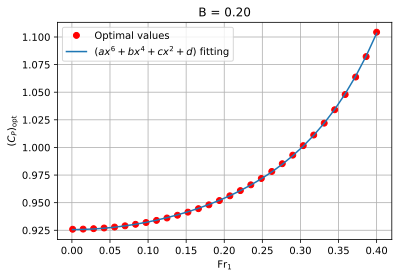

In [ ]:
mpl.plot( Fr1_opt_vec, C_P_opt_vec, 'ro', label="Optimal values" )
mpl.plot( Fr1_opt_vec, fit_C_P, label="$(ax^6+bx^4+cx^2+d)$ fitting" )

mpl.title( "B = %.2f" % B )
mpl.xlabel("$\mathrm{Fr}_1$")
mpl.ylabel("$(C_P)_\mathrm{opt}$")
mpl.legend(loc='upper left')
mpl.grid()

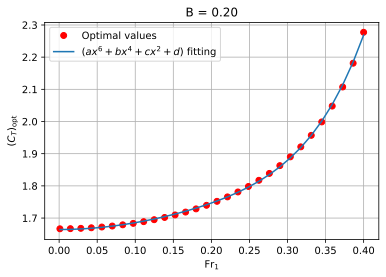

In [ ]:
mpl.plot( Fr1_opt_vec, C_T_opt_vec, 'ro', label="Optimal values" )
mpl.plot( Fr1_opt_vec, fit_C_T, label="$(ax^6+bx^4+cx^2+d)$ fitting" )

mpl.title( "B = %.2f" % B )
mpl.xlabel("$\mathrm{Fr}_1$")
mpl.ylabel("$(C_T)_\mathrm{opt}$")
mpl.legend(loc='upper left')
mpl.grid()